# GRILLA DE NxN CONDICIONES INICIALES EN a Y e

Sistema binario de estrellas de igual masa, con semieje de a = 0.1

Planeta circunbinario, creo una grilla de condiciones iniciales para a y e, integro para cada punto de la grilla, y guardo la excentricidad máxima que alcanzó ese par de condiciones iniciales.

a : [0.3 - 0.5]  N = 100

e : [0 - 0.275]  M = 100

In [2]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

pi = -4*np.arctan(-1)

### PARÁMETROS

In [2]:
N = 100                        # a
M = 100                        # e

a_ini = 0.3                    # extremos
a_fin = 0.5                    # en a

e_ini = 0.                     # extremos
e_fin = 0.275                  # en e

m0 = 0.5                       # masa de estrella primaria
m1 = 0.5                       # masa de estrella secundaria
m2 = 0.5e-3                    # masa del planeta

a1 = 0.1                       # semieje entre estrellas

### SIMULACIÓN

In [5]:
p = 0                          # parametro utilizado para el procentaje que se muestra mientras se corre el codigo

f = []

for a_ind in range(N):
    
    a_i = (a_ind/(N-1))*(a_fin-a_ini) + a_ini         # a : 0.1 -> 0.5
    
    
    for e_ind in range(M):
        
        e_i = (e_ind/(N-1))*(e_fin-e_ini) + e_ini      # e : 0.1 -> 0.3
        
        sim = rebound.Simulation()

        sim.add(m=0.5)                                           # primaria
        sim.add(m=0.5,a=0.1,e=0.5,inc=0,l=0,Omega=0,pomega=0)    # secundaria
        
        sim.add(m=0.5e-3,a=a_i,e=e_i)                            # particula

        # ---------------------- integramos

        os = sim.calculate_orbits()
        sim.integrator = "whfast" 
        sim.dt = 0.05 * os[0].P  # dt = 5% del periodo de la orbita mas chica
        Nout = 300               # number of points to display
        tmax = 2*365.25          # integrar por 2 yr
        Nmoons = 2

        ecc = np.zeros((Nmoons,Nout))

        times = np.linspace(0.,tmax,Nout)
        ps = sim.particles
        
        for i,time in enumerate(times):
            
            sim.integrate(time)
            os = sim.calculate_orbits()
            
            ecc[1][i] = os[1].e                     # lista de excentricidades para esta particula
            
            if np.isnan(os[1].e) == True:
                break
        
        p = p+1                                     #
        perc = np.round((p/(N*M))*100,decimals=1)   #  porcentaje de progreso del programa
        print(str(perc)+'%',end='\r')               #
        
        sim.save("checkpoint.bin")

        f.append([a_ind,e_ind,np.max(ecc[1]),a_i,e_i])
        
open('test4.txt', 'w').close()
np.savetxt('test4.txt',f,fmt=['%.1i','%4.1i','%6.4f','%6.4f','%6.4f'])

#### Leer datos

In [3]:
emax = np.genfromtxt('test4.txt',usecols=[2])

emax = np.reshape(emax,[N,M])
emax = np.transpose(emax)

### RESONANCIA EN FUNCIÓN DE a (PARA EL EJE SUPERIOR DEL GRÁFICO)

In [4]:
mu = (m0+m1)/(m0+m1+m2)      # razon de masas

def res(a_l):
    x_l = []
    for i in a_l:
        x = np.sqrt(((i/a1)**3)*mu)
        x = np.round(x,decimals=1)
        x_l.append(x)
    return x_l

### GRÁFICO

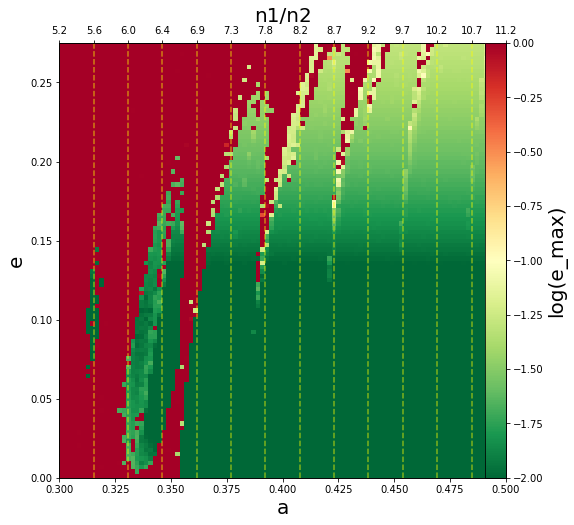

In [10]:
plt.figure(figsize=(8*(N/M),8))      # tamaño del plot
ax = plt.subplot(111)
plt.xlabel('a',fontsize=20)          #  nombres de
plt.ylabel('e',fontsize=20)          #  los ejes


# LEEMOS LOS DATOS

im = ax.imshow(np.log(emax),vmin=-2,vmax=0,origin='lower',aspect='auto',extent=[a_ini,a_fin,e_ini,e_fin],cmap="RdYlGn_r")



# RESONANCIAS A MOSTRAR EN EL EJE SUPERIOR

N_res = 14                                # numero de resonancias a mostrar en el eje

ax2 = plt.twiny()                        # eje de resonancias (superior)

ax2_t = np.linspace(a_ini,a_fin,N_res)   # lista de "a" para las cuales quiero ver las resonancias 
ax2.set_xticks(ax2_t)                    # en que valores de "a" va a escribir las resonancias 
ax2.set_xticklabels(res(ax2_t))          # valor de las resonancias para la lista de a anterior
ax2.set_xlim([a_ini,a_fin])              # es necesario

ax2.set_xlabel('n1/n2',fontsize=20)      # nombre del eje

for i in ax2_t:
    ax.vlines(i,e_ini,e_fin,linestyles='dashed',color='yellow',alpha=0.5)

# CONFIGURACION DE LA BARRA DE COLOR

divider = make_axes_locatable(ax)                         #   crear la barra
cax = divider.append_axes("right", size="5%", pad=0.05)   #   de colores a la derecha

cb = plt.colorbar(im, cax=cax)
cb.set_label('log(e_max)',fontsize=20)
plt.show()